In [3]:
# Core libraries
import os
import warnings
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras (optional; safely wrapped to avoid crash if not installed)
try:
    import tensorflow as tf
    from tensorflow.keras import layers
    from tensorflow.keras.preprocessing import image
    print(f"TensorFlow loaded: v{tf.__version__}")
except ImportError:
    tf = None
    print("TensorFlow is not installed. Skipping related imports.")

# Image processing
from PIL import Image
from skimage import io

# Geospatial
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
from shapely.errors import GEOSException

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity

# IPython magic (only for notebooks)
# %matplotlib inline

# Fix for deprecation warning
np.bool = bool

# Suppress warnings
warnings.filterwarnings("ignore")


TensorFlow loaded: v2.15.0


## Overview of Dataset
First I look at the structure of the dataset. The images are seperated into four folders (training, validation, and two test sets) each with subfolders for damage and no damage classes.

The training set contains 5,000 damage images and 5,000 no damage images. The validation and test set each contain 1,000 images of each class. Test set 2 contains 2,000 no damage images and 8,000 damage images, representing a situation where there is a class imbalance.

The images are 128x128 pixels. The filenames include latitude and longitude coordinates which can be used to plot the locations of the structures in relation to each other (see below).

In [4]:

# Update directory path based on your folder structure
DIR = "/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane"

folders = ['train_another', 'validation_another', 'test', 'test_another']
for folder in folders:
    folder_path = os.path.join(DIR, folder)
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} does not exist.")
    else:
        print(f'-------{folder.upper()}-------')
        for category in ['no_damage', 'damage']:
            category_path = os.path.join(folder_path, category)
            if os.path.exists(category_path):
                count = len(os.listdir(category_path))
                print(f"{category.capitalize()}: {count}")
            else:
                print(f"Warning: {category_path} does not exist.")

def load_image(fp, size=(128,128)):
    img = Image.open(fp).convert('RGB').resize(size)
    return np.array(img)

train_dir = os.path.join(DIR, 'train_another')
if os.path.exists(train_dir):
    damage_imgs = [fn for fn in os.listdir(f'{train_dir}/damage') if fn.endswith('.jpeg')]
    no_damage_imgs = [fn for fn in os.listdir(f'{train_dir}/no_damage') if fn.endswith('.jpeg')]

    damage_df = pd.DataFrame(damage_imgs, columns=['Filename'])
    damage_df[['lon', 'lat']] = damage_df['Filename'].str.replace('.jpeg', '', regex=False).str.split('_', expand=True)
    damage_df['damage'] = 1

    no_damage_df = pd.DataFrame(no_damage_imgs, columns=['Filename'])
    no_damage_df[['lon', 'lat']] = no_damage_df['Filename'].str.replace('.jpeg', '', regex=False).str.split('_', expand=True)
    no_damage_df['damage'] = 0

    all_df = pd.concat([damage_df, no_damage_df])
    all_df['lon'] = pd.to_numeric(all_df['lon'], errors='coerce')
    all_df['lat'] = pd.to_numeric(all_df['lat'], errors='coerce')

    all_df = all_df.dropna(subset=['lon', 'lat']).drop_duplicates()

-------TRAIN_ANOTHER-------
No_damage: 5000
Damage: 5000
-------VALIDATION_ANOTHER-------
No_damage: 1000
Damage: 1000
-------TEST-------
No_damage: 1000
Damage: 1000
-------TEST_ANOTHER-------
No_damage: 1000
Damage: 8000


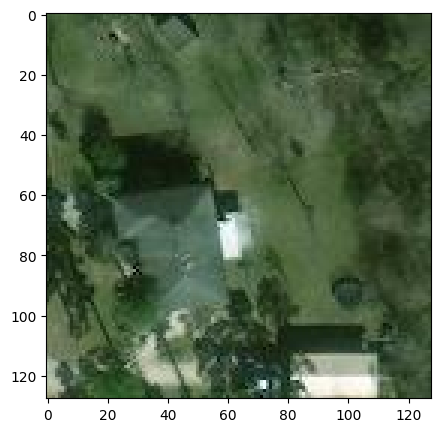

In [5]:
#load a sample image
tile_path = os.path.join(DIR, 'train_another', 'no_damage' , '-95.086_29.827665000000003.jpeg')
tile = io.imread(tile_path)

#plot image
plt.figure(figsize=(5,5))
plt.imshow(tile);

In [6]:
import os

path = "/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/train_another/damage"
try:
    print("Files:", os.listdir(path))
except PermissionError:
    print("Permission denied for:", path)


Files: ['-95.63609699999999_29.843807.jpeg', '-95.564464_29.760775.jpeg', '-95.634153_29.848823.jpeg', '-95.55676600000001_29.771306.jpeg', '-95.626439_29.859842999999998.jpeg', '-93.975009_29.902387.jpeg', '-95.120897_30.027523.jpeg', '-95.61993199999999_29.76796.jpeg', '-96.897634_28.461071.jpeg', '-96.963335_28.482421000000002.jpeg', '-95.115997_30.043471000000004.jpeg', '-95.63036600000001_29.855165000000003.jpeg', '-93.665072_30.139546000000003.jpeg', '-93.667547_30.143409000000002.jpeg', '-95.596919_29.757876.jpeg', '-95.533979_29.748125.jpeg', '-95.63525600000001_29.84259.jpeg', '-93.979417_29.901393.jpeg', '-96.983859_28.802357.jpeg', '-96.98304_28.458609999999997.jpeg', '-95.62772700000001_29.859982000000002.jpeg', '-95.637045_29.774099.jpeg', '-95.642484_29.771559000000003.jpeg', '-96.898199_28.642709000000004.jpeg', '-95.099691_29.837028999999998.jpeg', '-93.985512_29.8935.jpeg', '-95.139877_29.992889.jpeg', '-96.895744_28.706163.jpeg', '-93.98659_30.126269.jpeg', '-95.63876

In [7]:
import tensorflow as tf
import os

# Define directory and parameters
DIR = "/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane"
image_size = (128, 128)
batch_size = 32
seed = 42

train_dir = os.path.join(DIR, 'train_another')
val_dir = os.path.join(DIR, 'validation_another')

# Step 1: Check for corrupted images
num_skipped = 0
for folder_name in ("damage", "no_damage"):
    folder_path = os.path.join(train_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with open(fpath, "rb") as fobj:
                is_jfif = b"JFIF" in fobj.peek(10)
        except Exception as e:
            print(f"Error reading file {fpath}: {e}")
            is_jfif = False

        if not is_jfif:
            num_skipped += 1
            print(f"Corrupted: {fpath}")
            # os.remove(fpath)  # Uncomment to delete

print(f"\nTotal corrupted images found: {num_skipped}")

# Step 2: Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)

# Step 3: Normalize and prefetch datasets
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



Total corrupted images found: 0
Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [8]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 🔁 Set the base image directory
image_dir = "/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/train_another"

# 📂 Collect image metadata
image_data = []

for label in ["damage", "no_damage"]:
    folder = os.path.join(image_dir, label)
    for fname in os.listdir(folder):
        if fname.endswith(".jpeg") or fname.endswith(".jpg") or fname.endswith(".png"):
            try:
                # Example: "-93.6141_30.754263.jpeg"
                lon_str, lat_str = fname.replace(".jpeg", "").replace(".jpg", "").replace(".png", "").split("_")
                lon, lat = float(lon_str), float(lat_str)
                image_data.append({"filename": fname, "label": label, "lat": lat, "lon": lon})
            except Exception as e:
                print(f"❌ Skipping invalid filename: {fname} ({e})")

# 🧾 Create DataFrame
all_df = pd.DataFrame(image_data)

# 🌍 Create GeoDataFrame
try:
    all_df['geometry'] = all_df.apply(
        lambda row: Point(row['lon'], row['lat']) if pd.notnull(row['lon']) and pd.notnull(row['lat']) else None,
        axis=1
    )
    all_df = all_df.dropna(subset=['geometry'])

    all_gdf = gpd.GeoDataFrame(all_df, geometry='geometry', crs='EPSG:4326').to_crs(epsg=3857)
    print("✅ GeoDataFrame created successfully!")
    print(all_gdf.head())

except Exception as e:
    print(f"❌ Error creating GeoDataFrame: {e}")


✅ GeoDataFrame created successfully!
                             filename   label        lat        lon  \
0   -95.63609699999999_29.843807.jpeg  damage  29.843807 -95.636097   
1           -95.564464_29.760775.jpeg  damage  29.760775 -95.564464   
2           -95.634153_29.848823.jpeg  damage  29.848823 -95.634153   
3   -95.55676600000001_29.771306.jpeg  damage  29.771306 -95.556766   
4  -95.626439_29.859842999999998.jpeg  damage  29.859843 -95.626439   

                            geometry  
0  POINT (-10646161.619 3483488.448)  
1   POINT (-10638187.47 3472836.615)  
2  POINT (-10645945.214 3484132.213)  
3  POINT (-10637330.533 3474187.104)  
4   POINT (-10645086.496 3485546.66)  


## Load and Flatten Pixel Data

In [9]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Set directory
train_dir = "/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/train_another"

# Function to load and flatten images
def load_and_flatten_image(fp, size=(64, 64)):
    img = Image.open(fp).convert('RGB').resize(size)
    return np.array(img).flatten()

# Get image filenames
damage_dir = os.path.join(train_dir, 'damage')
no_damage_dir = os.path.join(train_dir, 'no_damage')

damage_imgs = [img for img in os.listdir(damage_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
no_damage_imgs = [img for img in os.listdir(no_damage_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]

# Get file paths (limit to 100 each)
damage_paths = [os.path.join(damage_dir, img) for img in damage_imgs[:100]]
no_damage_paths = [os.path.join(no_damage_dir, img) for img in no_damage_imgs[:100]]

# Combine and label
image_data = []
labels = []

for path in damage_paths:
    image_data.append(load_and_flatten_image(path))
    labels.append(1)

for path in no_damage_paths:
    image_data.append(load_and_flatten_image(path))
    labels.append(0)

# Convert to DataFrame
pixel_df = pd.DataFrame(image_data)
pixel_df['label'] = labels

print("✅ Pixel DataFrame created successfully!")
print(pixel_df.shape)
print(pixel_df.head())


✅ Pixel DataFrame created successfully!
(200, 12289)
    0   1   2   3   4   5   6   7   8   9  ...  12279  12280  12281  12282  \
0  48  59  42  55  67  47  59  72  52  58  ...     48     63     39     55   
1  47  55  45  50  59  45  52  65  43  52  ...    133    129     97    135   
2  60  72  48  60  72  48  57  69  45  62  ...     76     91     64     78   
3  37  58  37  38  59  38  41  60  40  42  ...    118    112     86    121   
4  59  74  55  54  69  50  49  64  45  48  ...     59     71     59     58   

   12283  12284  12285  12286  12287  label  
0     70     47     56     71     48      1  
1    130     98    134    129     97      1  
2     95     65     82    101     69      1  
3    114     88    119    111     84      1  
4     70     58     60     73     61      1  

[5 rows x 12289 columns]


## PCA Visualization

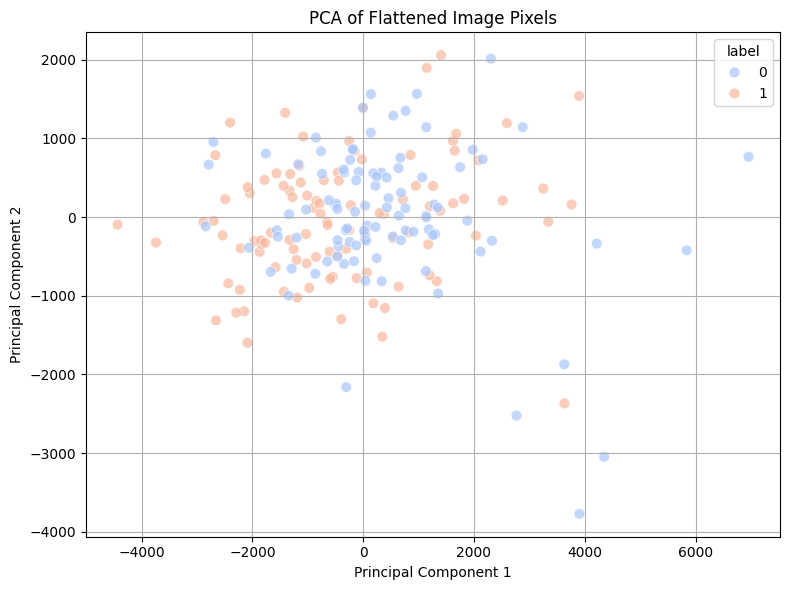

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Ensure pixel_df exists and 'label' column is present
X = pixel_df.drop('label', axis=1)
y = pixel_df['label']

# Run PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
components = pca.fit_transform(X)

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=y, palette='coolwarm', s=60, alpha=0.7)
plt.title("PCA of Flattened Image Pixels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## Pixel Intensity Distribution

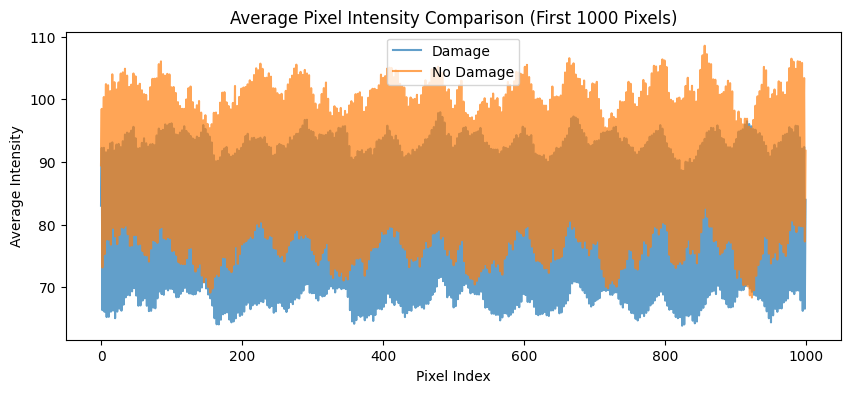

In [11]:
damage_pixels = pixel_df[pixel_df['label'] == 1].drop('label', axis=1).mean()
no_damage_pixels = pixel_df[pixel_df['label'] == 0].drop('label', axis=1).mean()

plt.figure(figsize=(10, 4))
plt.plot(damage_pixels.values[:1000], label='Damage', alpha=0.7)
plt.plot(no_damage_pixels.values[:1000], label='No Damage', alpha=0.7)
plt.legend()
plt.title("Average Pixel Intensity Comparison (First 1000 Pixels)")
plt.xlabel("Pixel Index")
plt.ylabel("Average Intensity")
plt.show()


## Heatmap of Mean Images

## Average Image by Class
Here I find the average value for each pixel and then generate an "average image" for each class in order to compare.

For both damage and no damage images we see that a structure tends to be located within the center of the image.

For damage images, the pixel values around the structure tend to be lower in value than around the no damage images. Perhaps this is because damage images tend to have flood waters around the structures, which are a different color than unflooded ground.

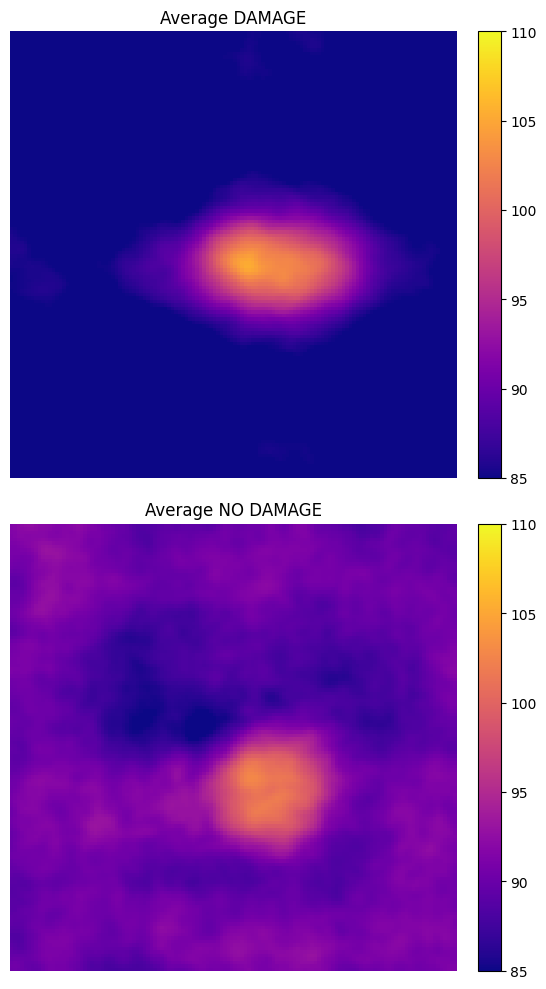

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from scipy.ndimage import gaussian_filter

# Set your training directory
train_dir = "/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/train_another"
damage_dir = os.path.join(train_dir, "damage")
no_damage_dir = os.path.join(train_dir, "no_damage")

# Utility to crop center of image
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty + cropy, startx:startx + cropx]

# Load and preprocess images
def load_images(path, filenames, size=(128, 128), crop_size=(128, 128)):
    image_matrix = []
    for fn in filenames:
        try:
            fp = os.path.join(path, fn)
            img = image.load_img(fp, target_size=size, color_mode='rgb')
            arr = image.img_to_array(img)
            gray = np.mean(arr, axis=2)  # Convert to grayscale
            if crop_size != size:
                gray = crop_center(gray, *crop_size)
            image_matrix.append(gray.ravel())
        except Exception as e:
            print(f"Skipping {fn}: {e}")
    return np.array(image_matrix)

# Get filenames
damage_files = [f for f in os.listdir(damage_dir) if f.endswith(".jpeg")][:1000]  # Adjust sample size as needed
no_damage_files = [f for f in os.listdir(no_damage_dir) if f.endswith(".jpeg")][:1000]

# Load images
damage_arrays = load_images(damage_dir, damage_files, size=(128, 128), crop_size=(128, 128))
no_damage_arrays = load_images(no_damage_dir, no_damage_files, size=(128, 128), crop_size=(128, 128))

# Function to calculate and optionally sharpen mean image
def find_mean_img(full_mat, title, size=(128, 128), sharpen=True):
    mean_img = np.mean(full_mat, axis=0).reshape(size)
    if sharpen:
        mean_img = gaussian_filter(mean_img, sigma=1)
    return mean_img

# Compute mean images
damage_mean = find_mean_img(damage_arrays, 'DAMAGE', size=(128, 128))
no_damage_mean = find_mean_img(no_damage_arrays, 'NO DAMAGE', size=(128, 128))

# === Plot both with consistent color scale and plasma colormap ===
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

im1 = axs[0].imshow(damage_mean, cmap='plasma', vmin=85, vmax=110)
axs[0].set_title("Average DAMAGE")
axs[0].axis('off')
plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

im2 = axs[1].imshow(no_damage_mean, cmap='plasma', vmin=85, vmax=110)
axs[1].set_title("Average NO DAMAGE")
axs[1].axis('off')
plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## Standard Deviation by Class
The function below is similar to above but instead of calculating the mean pixel value it plots the the standard deviation for each pixel for each class.

Standard deviation around the edges of the image appears to be (slightly) greater for the no damage images. Perhaps this is because materials/visible ground around the structures creates more variation between images in that class.

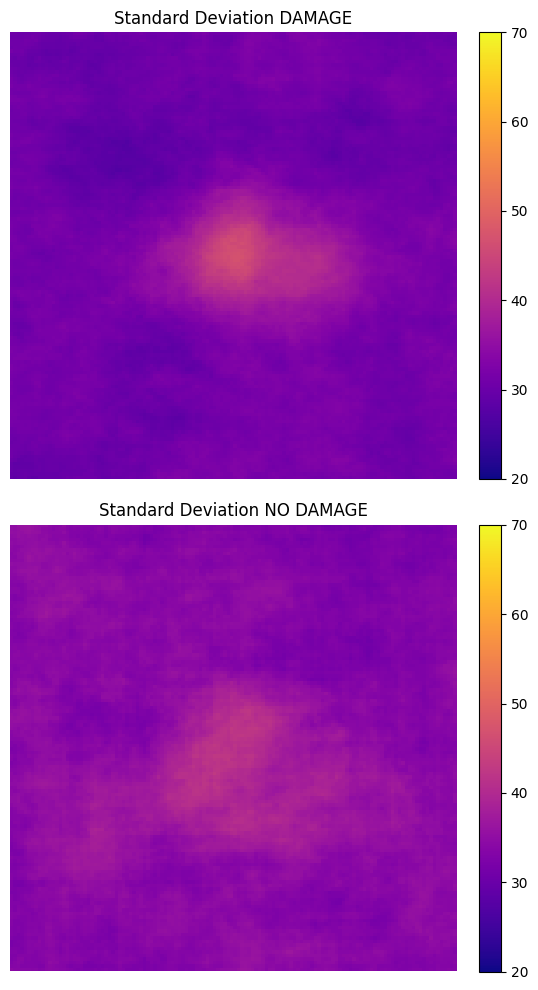

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Compute Standard Deviation Images ===
damage_std = np.std(damage_arrays, axis=0).reshape((128, 128))
no_damage_std = np.std(no_damage_arrays, axis=0).reshape((128, 128))

# === Step 2: Plot both side-by-side with consistent color scale and colormap ===
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# Plot DAMAGE standard deviation
im1 = axs[0].imshow(damage_std, cmap='plasma', vmin=20, vmax=70)
axs[0].set_title("Standard Deviation DAMAGE")
axs[0].axis('off')
plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

# Plot NO-DAMAGE standard deviation
im2 = axs[1].imshow(no_damage_std, cmap='plasma', vmin=20, vmax=70)
axs[1].set_title("Standard Deviation NO DAMAGE")
axs[1].axis('off')
plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## Contrast between average images
Here I plotted the difference between the mean images for the two classes (damage and no damage). Dark blue and dark red are where there is the greatest difference and white is where there is the least.

The white pixels appear to form the outline of a structure - this is expected since all images of both classes have a structure in the center of the image. The difference values are higher in the center (roof?) and edges (area surrounding the structure).

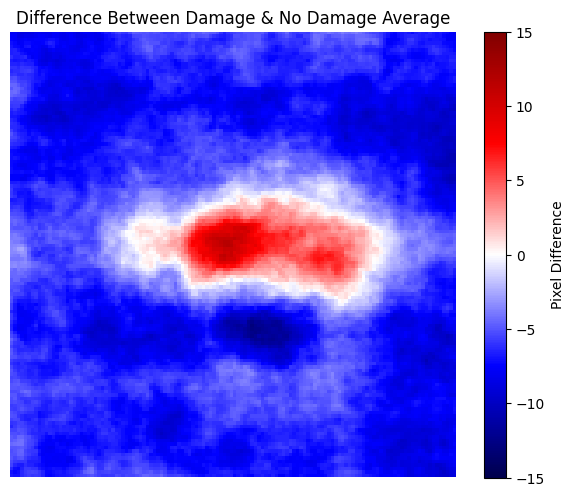

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Compute mean images ===
damage_mean = np.mean(damage_arrays, axis=0).reshape((128, 128))
no_damage_mean = np.mean(no_damage_arrays, axis=0).reshape((128, 128))

# === Step 2: Calculate raw difference ===
diff_img = damage_mean - no_damage_mean

# === Step 3: Plot the difference heatmap ===
plt.figure(figsize=(6, 5))
plt.imshow(diff_img, cmap='seismic', vmin=-15, vmax=15)
plt.title("Difference Between Damage & No Damage Average")
plt.axis('off')
plt.colorbar(label="Pixel Difference")
plt.tight_layout()
plt.show()


## Eigenimages
The functions below leverage PCA to produce eigenimages for the two image classes. The eigenimages are not easily recognizable to the human eye, unlike eignimages based on faces or other images with more regular repeating features. There are hints of basic geometric shapes with right angles, as would be expected from images of structures.

It is telling, however, that when the function is told to produce eigenimages that produce 70% of the variation in each class, the damage class only requires 19 principle components while the no damage class requires 56. This is consistent with our earlier finding that the standard deviation for pixel values across the no damage class tended to be higher than the damage class.

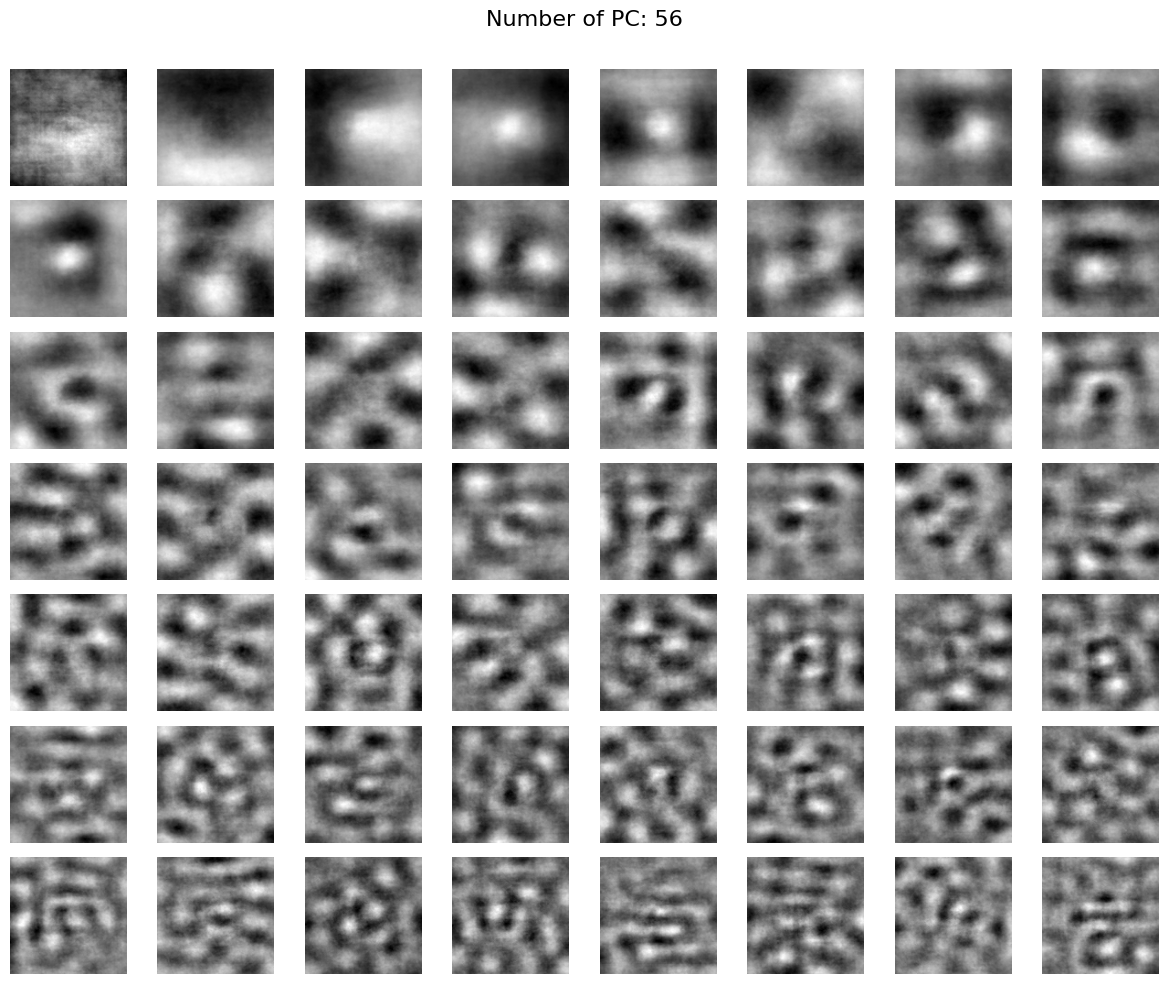

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Step 1: Stack all images into a matrix (grayscale, flattened)
all_images = np.vstack([damage_arrays, no_damage_arrays])  # Shape: (num_images, 128*128)

# === Step 2: Perform PCA
num_components = 56
pca = PCA(n_components=num_components)
pca.fit(all_images)

# === Step 3: Extract eigenvectors (principal components)
eigenimages = pca.components_.reshape((num_components, 128, 128))

# === Step 4: Plot eigenimages
fig, axs = plt.subplots(7, 8, figsize=(12, 10))  # Adjust grid based on num_components
axs = axs.flatten()

for i in range(num_components):
    axs[i].imshow(eigenimages[i], cmap='gray')
    axs[i].axis('off')

# If fewer axes than grid, hide the rest
for j in range(num_components, len(axs)):
    axs[j].axis('off')

plt.suptitle(f'Number of PC: {num_components}', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## Geographic Distribution
Finally, I wanted to sense check the geographic distribution of the training data by class. This is possible because the GPS coordinates are contained in the filename for each image file. Here I create a dataframe with damage class and latitude/longitude coordinates by parsing the filenames. Then I convert this into a GeoDataFrame and plot against a basemap.

We can see that the training data appears to come from 3 distinct areas. In one area, all structures in the training dataset are damaged, while in the other two there is a mix. Within those two there are clear spatial patterns of where flooding/damage occured and where it didn't.

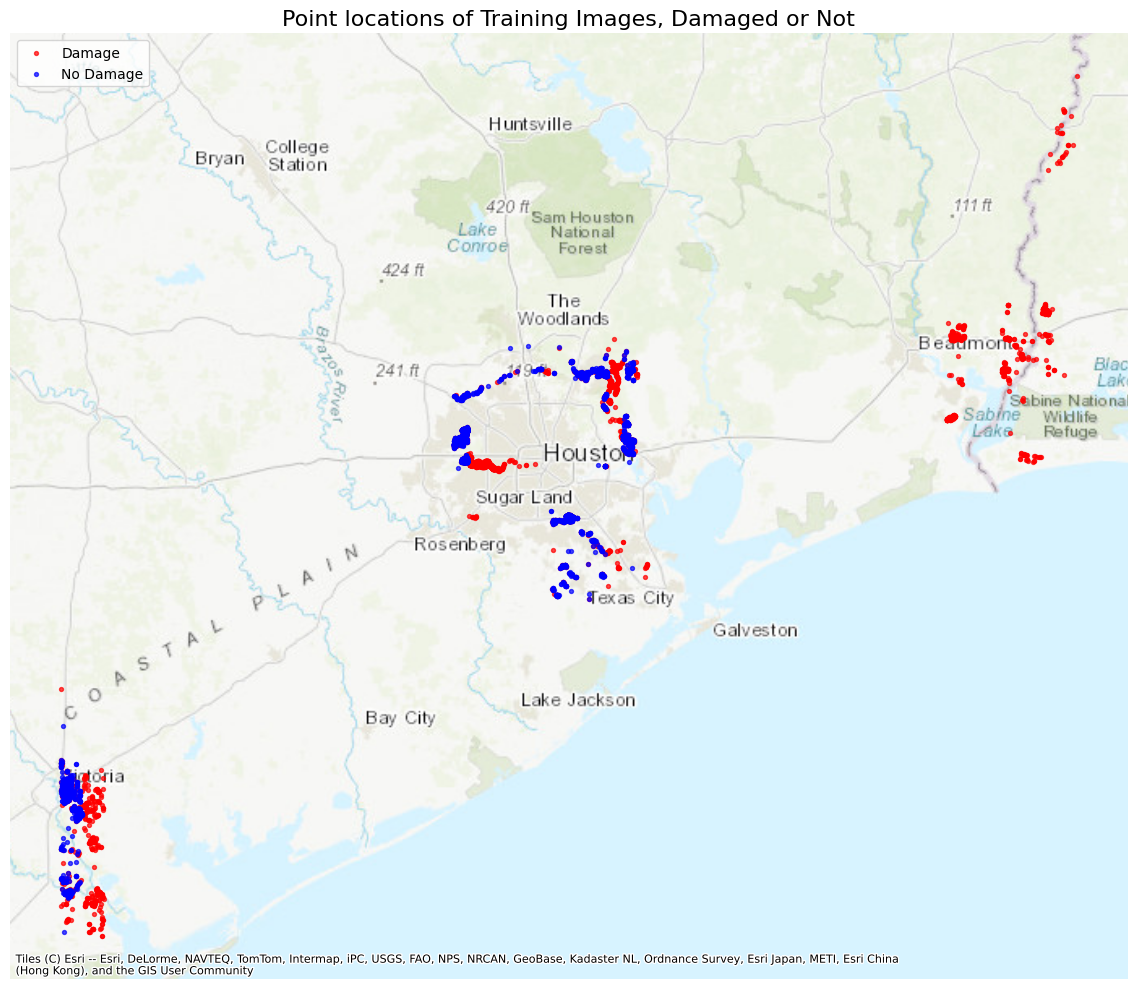

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Project to Web Mercator
all_gdf_web = all_gdf.to_crs(epsg=3857)

# Define color mapping for labels (assuming string values)
colors = {'no_damage': 'blue', 'damage': 'red'}
labels = {'no_damage': 'No Damage', 'damage': 'Damage'}

# Create plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot points by label
for label_val, group in all_gdf_web.groupby('label'):
    group.plot(
        ax=ax,
        markersize=8,
        color=colors[label_val],
        label=labels[label_val],
        alpha=0.7
    )

# ✅ Add Esri satellite basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)

# Final touches
ax.set_title("Point locations of Training Images, Damaged or Not", fontsize=16)
ax.legend()
ax.axis('off')
plt.tight_layout()
plt.show()


By plotting histograms of the distribution of longitudes we can see the trends displayed in the map confirmed. The damage class has three distinct groupings, while the no damage class has only two. This is because the northeastern group does not have any no damage cases.

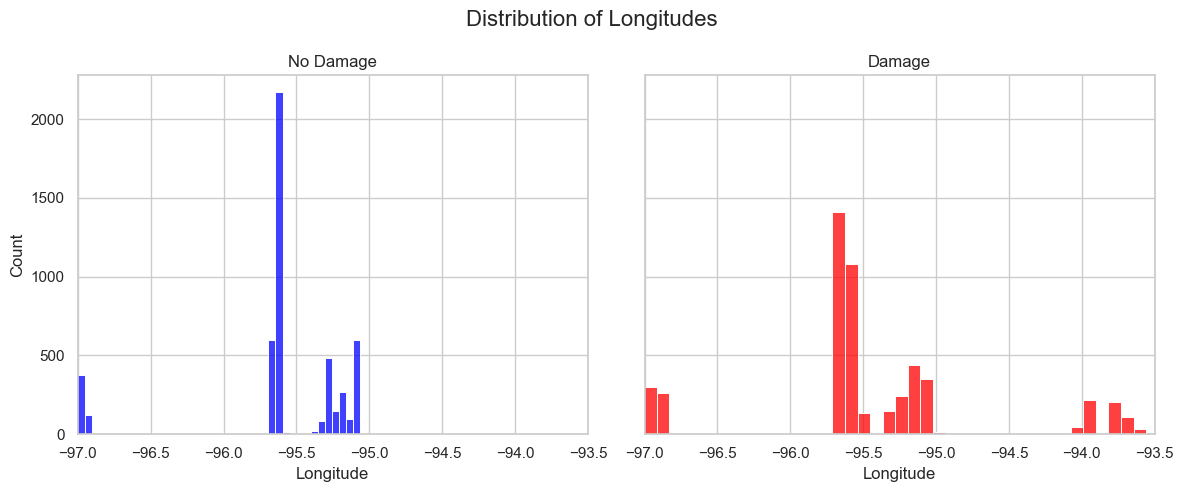

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle("Distribution of Longitudes", fontsize=16)

# Plot No Damage
sns.histplot(all_gdf[all_gdf['label'] == 'no_damage']['lon'], ax=ax1, color='blue', bins=40)
ax1.set_xlim([-97, -93.5])
ax1.set_title('No Damage')
ax1.set_xlabel('Longitude')

# Plot Damage
sns.histplot(all_gdf[all_gdf['label'] == 'damage']['lon'], ax=ax2, color='red', bins=40)
ax2.set_xlim([-97, -93.5])
ax2.set_title('Damage')
ax2.set_xlabel('Longitude')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


## 🔍 Interpretation of the Graph:
### 📌 No Damage (left plot):
-- Strong peak around ~–95.5

-- Very concentrated — suggests most no-damage images are from a specific geographic cluster

-- Small secondary group closer to –97 (likely a separate region like Victoria, TX)

### 📌 Damage (right plot):
-- Similar cluster around –95.5, but with:

-- More spread to the east (e.g., –94.5 to –93.5)

-- Additional eastern clusters near Port Arthur/Beaumont

-- A broader geographic spread overall

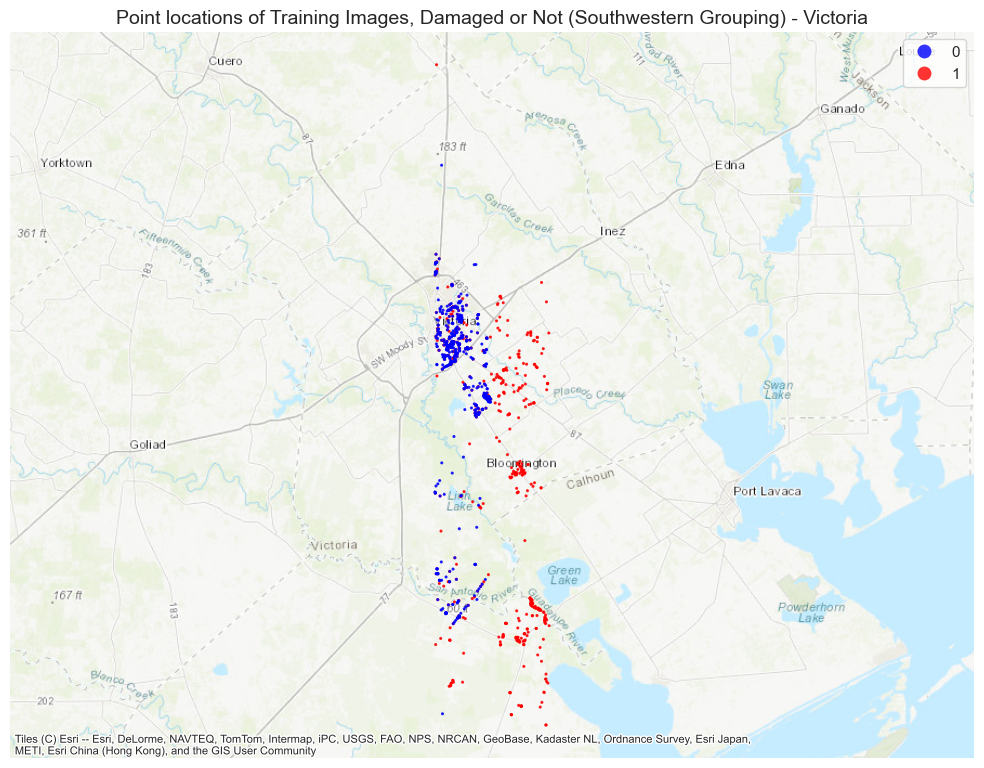

In [28]:
import matplotlib.pyplot as plt
import contextily as cx

# Copy and map label to numeric
all_gdf_copy = all_gdf.copy()
all_gdf_copy['label_numeric'] = all_gdf_copy['label'].map({'no_damage': 0, 'damage': 1})

# Filter for southwestern area and convert CRS
southern_gdf = all_gdf_copy[all_gdf_copy['lon'] < -96].to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

southern_gdf.plot(
    ax=ax,
    column='label_numeric',
    categorical=True,
    legend=True,
    alpha=0.8,
    markersize=1.5,
    cmap='bwr'  # 0: blue, 1: red
)

# Set bounding box (Victoria / Cuero / Port Lavaca region)
ax.set_xlim([-10798210.908 - 60000, -10782077.708 + 60000])

# ✅ Use hybrid basemap with place names
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap)

# Title & final touches
ax.set_title('Point locations of Training Images, Damaged or Not (Southwestern Grouping) - Victoria', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


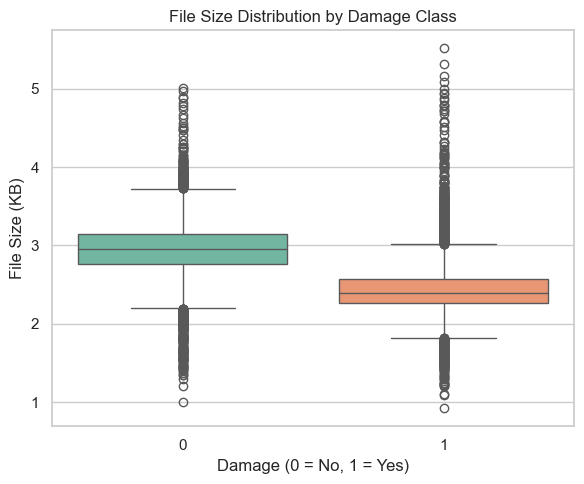

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define image directory
image_dir = "/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/train_another"

# Build full path to each image
all_gdf['file_path'] = all_gdf.apply(
    lambda row: os.path.join(image_dir, row['label'], row['filename']),
    axis=1
)

# Compute file size in kilobytes
all_gdf['file_size_kb'] = all_gdf['file_path'].apply(lambda x: os.path.getsize(x) / 1024)

# Map damage labels to numeric
all_gdf['damage'] = all_gdf['label'].map({'no_damage': 0, 'damage': 1})

# Plot boxplot of file sizes by class
plt.figure(figsize=(6, 5))
sns.boxplot(data=all_gdf, x='damage', y='file_size_kb', palette='Set2')
plt.xlabel("Damage (0 = No, 1 = Yes)")
plt.ylabel("File Size (KB)")
plt.title("File Size Distribution by Damage Class")
plt.tight_layout()
plt.show()


In [32]:
all_gdf

,filename,label,lat,lon,geometry,file_path,file_size_kb,damage
0,-95.63609699999999_29.843807.jpeg,damage,29.843807,-95.636097,POINT (-10646161.619 3483488.448),/Users/SRINIVAS/Documents/Capstone Project/Pos...,2.567383,1
1,-95.564464_29.760775.jpeg,damage,29.760775,-95.564464,POINT (-10638187.47 3472836.615),/Users/SRINIVAS/Documents/Capstone Project/Pos...,2.249023,1
2,-95.634153_29.848823.jpeg,damage,29.848823,-95.634153,POINT (-10645945.214 3484132.213),/Users/SRINIVAS/Documents/Capstone Project/Pos...,2.312500,1
3,-95.55676600000001_29.771306.jpeg,damage,29.771306,-95.556766,POINT (-10637330.533 3474187.104),/Users/SRINIVAS/Documents/Capstone Project/Pos...,2.453125,1
4,-95.626439_29.859842999999998.jpeg,damage,29.859843,-95.626439,POINT (-10645086.496 3485546.66),/Users/SRINIVAS/Documents/Capstone Project/Pos...,2.346680,1
...,...,...,...,...,...,...,...,...
9995,-95.631385_29.859282.jpeg,no_damage,29.859282,-95.631385,POINT (-10645637.082 3485474.65),/Users/SRINIVAS/Documents/Capstone Project/Pos...,2.748047,0
9996,-95.635776_29.773893.jpeg,no_damage,29.773893,-95.635776,POINT (-10646125.886 3474518.881),/Users/SRINIVAS/Documents/Capstone Project/Pos...,3.300781,0
9997,-95.198941_29.536098.jpeg,no_damage,29.536098,-95.198941,POINT (-10597497.636 3444057.86),/Users/SRINIVAS/Documents/Capstone Project/Pos...,2.518555,0
9998,-95.63910200000001_29.838984000000004.jpeg,no_damage,29.838984,-95.639102,POINT (-10646496.135 3482869.483),/Users/SRINIVAS/Documents/Capstone Project/Pos...,2.897461,0


## 🔍 Canny Edge Detection for Damage Feature Extraction
To enhance structural features that may indicate hurricane damage (e.g., debris, collapsed rooftops, or irregular building edges), we apply Canny Edge Detection to the satellite imagery. This process highlights sharp intensity transitions—typically boundaries or breaks in structures—making it easier to detect anomalies.

Below is an example applied to a damage-labeled image:

-- Image Path: -93.6141_30.754263.jpeg

-- Technique Used: cv2.Canny() with thresholds (100, 200)

The result is a grayscale image where prominent edges are clearly visible, helping us isolate structural deformations.

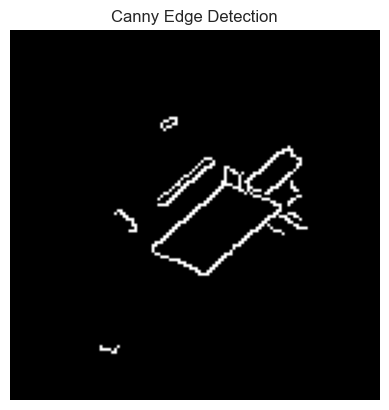

In [34]:
import cv2

img_path = '/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/train_another/damage/-93.6141_30.754263.jpeg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


if img is None:
    print("Image not found or invalid path:", img_path)
else:
    edges = cv2.Canny(img, threshold1=100, threshold2=200)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edge Detection")
    plt.axis('off')
    plt.show()



## GLCM-Based Texture Feature Extraction
Objective: Extract statistical texture features that characterize surface differences in damaged vs. undamaged areas (e.g., cracked roofs, debris textures).

### Method:
We compute the Gray Level Co-occurrence Matrix (GLCM), which captures how often pairs of pixel intensities occur in an image with a defined spatial relationship. From this matrix, we derive key texture descriptors:

-- Contrast – Measures local intensity variation (higher for sharp edges, damage).

-- Correlation – Measures how correlated a pixel is with its neighbor across the image.

-- Energy – Sum of squared elements in the GLCM; higher for uniform textures.

-- Homogeneity – Closeness of the distribution of elements to the diagonal (smooth regions).

In [35]:
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
import numpy as np

# Load and convert image
img = imread(img_path)
gray = rgb2gray(img)
gray_u8 = img_as_ubyte(gray)  # Convert to uint8

# Compute GLCM
glcm = graycomatrix(gray_u8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

# Extract features
contrast = graycoprops(glcm, 'contrast')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

print("GLCM Features → Contrast:", contrast, "| Correlation:", correlation)


GLCM Features → Contrast: 51.60728346456693 | Correlation: 0.974922597610209


# Setup and Data Preparation

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
train_dir = '/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/train_another'
val_dir = '/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/validation_another'

# Basic Transform (Resize + Normalize)
transform_base = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


Using device: cpu


# Loading Datasets

In [38]:
from torchvision.datasets import ImageFolder

# Paths
test_dir = '/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/test'

# Load datasets (no augmentation)
train_dataset = ImageFolder(root=train_dir, transform=transform_base)
val_dataset = ImageFolder(root=val_dir, transform=transform_base)
test_dataset = ImageFolder(root=test_dir, transform=transform_base)

# DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['damage', 'no_damage']


# Dataloaders with Image Augmentation (Training Only)

In [39]:
# Augmentation: flip, rotate, color jitter — suitable for aerial image variation
transform_augmented = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Re-define datasets
augmented_train_dataset = ImageFolder(root=train_dir, transform=transform_augmented)
val_dataset = ImageFolder(root=val_dir, transform=transform_base)

# Dataloaders
train_loader_augmented = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Same as before


# Tracking & Plotting Training History

In [41]:
import matplotlib.pyplot as plt

def plot_nn_training(history):
    """
    Given training history (dict), plot training and validation accuracy and loss.
    """
    # Accuracy
    plt.figure(figsize=(10,4))
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(10,4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# Keras Baseline CNN Model – No Augmentation

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Dense
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import os

# Build baseline CNN model
model = Sequential()

# Input scaling
model.add(Rescaling(1.0 / 255, input_shape=(128, 128, 3)))

# Convolutional layers
model.add(Conv2D(32, kernel_size=5, strides=2, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Output layer for binary classification (2 classes)
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])


# Callbacks: EarlyStopping + Save Best Model

In [43]:
# Create directory if not exists
os.makedirs('models/Model1', exist_ok=True)

# Callbacks
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
mc = ModelCheckpoint('models/Model1/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)


# Train the Model

In [44]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/train_another"
val_dir = "/Users/SRINIVAS/Documents/Capstone Project/Post-hurricane/validation_another"

# Load training data (no augmentation)
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

# Load validation data
val_ds = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)


Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [45]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
